In [27]:
import io
import copy
from fastapi import FastAPI, Depends, APIRouter, UploadFile, File, HTTPException
from pydantic import BaseModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Union, Annotated
from models_store import get_models
from functions import create_new_features,\
                      red_blue_streak_diff_calc,\
                      drop_features,\
                      show_predictions
                      
import joblib
from models import RNNModel 
import torch
from torch.utils.data import Dataset, DataLoader

In [4]:
# Переменная для хранения загруженных данных
df_test: pd.DataFrame = pd.DataFrame()

# Модель, выбранная для предсказания
selected_model = None
selected_model_name = None

In [5]:
df_test = pd.read_csv('../api_test_data/test_event.csv', index_col='Unnamed: 0')
df_test

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,RedOdds,BlueOdds,RMatchWCRank,BMatchWCRank,RedWinsByDecision,RedWinsByKO_TKO,BlueWinsByDecision,BlueWinsByKO_TKO,RedTimeSinceLastFight,BlueTimeSinceLastFight
340,Alex Pereira,Jamahal Hill,6,0,1.0,36,193.04,200.66,205,0.0,...,-130.0,110.0,16.0,15.0,2,4,2,5,154,448
341,Zhang Weili,Yan Xiaonan,0,1,1.0,34,162.56,160.02,115,1.0,...,-455.0,350.0,16.0,15.0,4,2,7,1,238,343
342,Justin Gaethje,Max Holloway,3,0,0.0,35,180.34,177.80,155,0.0,...,-185.0,154.0,14.0,0.0,2,6,9,10,259,231
343,Charles Oliveira,Arman Tsarukyan,3,0,0.0,34,177.80,187.96,155,0.0,...,190.0,-218.0,15.0,12.0,2,4,4,4,308,133
344,Bo Nickal,Cody Brundage,5,0,0.0,28,185.42,193.04,185,1.0,...,-1600.0,900.0,0.0,0.0,0,1,0,2,280,133
345,Jiri Prochazka,Aleksandar Rakic,6,0,0.0,31,190.50,203.20,205,0.0,...,105.0,-125.0,0.0,0.0,0,2,4,2,154,700
346,Calvin Kattar,Aljamain Sterling,2,0,0.0,36,180.34,182.88,145,0.0,...,154.0,-185.0,8.0,0.0,3,4,8,2,532,238
348,Sodiq Yusuff,Diego Lopes,2,0,0.0,30,175.26,180.34,145,0.0,...,120.0,-142.0,3.0,0.0,4,2,0,1,182,154


In [6]:
def select_model(model_name: str, models: Dict[str, Any] = Depends(get_models)):
    global selected_model, selected_model_name

    if model_name not in models:
        raise HTTPException(status_code=400, detail=f"Model {model_name} not found.")
    
    selected_model_name = model_name
    selected_model = models[model_name]  # Полностью копируем объект из словаря models
    return selected_model

In [51]:
selected_model = joblib.load('../models/rnn_model.joblib')
# selected_model = joblib.load('../models/xgboost_model.joblib')

In [15]:
 # Создаем копию данных, чтобы не изменять оригинальные данные
test_data = copy.deepcopy(df_test)
# Применяем функции, отвечающие за создание новых признаков и удаление ненужных
test_data  = create_new_features(test_data)
test_data ['Curr_streak_diff'] = test_data.apply(red_blue_streak_diff_calc, axis=1)
test_data = drop_features(test_data)
# Загружаем сохраненный скейлер и применяем его к тестовым данным
scaler = joblib.load('../models/ufc_stand_scaler.joblib')
test_data = scaler.transform(test_data)

In [16]:
def run_xgboost_model_prediction(model: Any, df_test: np.array) -> Dict:
    """
    Запуск предсказания модели XGBoost. 
    Возвращает словарь:
    model: модель,
    y_pred: предсказанные метки класса,
    y_proba: вероятности предсказаний
    """
    # Получаем предсказания загруженной модели 
    y_pred = model.predict(df_test)
    y_proba = model.predict_proba(df_test)  

    return {'model': model,'y_pred': y_pred, 'y_proba': y_proba}

In [9]:
def run_rnn_model_prediction(model: Any, df_test: np.array) -> Dict:
    """
    Запуск предсказания модели RNN. 
    Возвращает словарь:
    model: модель,
    y_pred: предсказанные метки класса,
    y_proba: вероятности предсказаний
    """

    # Создаем DataLoader для тестовых данных
    test_dataloader = DataLoader(df_test, batch_size=32, shuffle=False)
    model.eval()# Переключаем модель в режим оценки
    y_pred = []
    y_proba = []
    with torch.no_grad():  # Отключаем обратное распространение ошибок
        for batch in test_dataloader:
            inputs = batch.float()
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            y_pred.extend(predicted.numpy().flatten())            
            y_proba.extend(outputs.numpy().flatten())     

   # Преобразовать списки в numpy массивы
    y_pred = np.array(y_pred)
    y_proba_1 = np.array(y_proba)
    y_proba_0 = 1 - np.array(y_proba)
    
    y_proba = np.stack((y_proba_0, y_proba_1), axis=1)  

    return {'model': model,'y_pred': y_pred, 'y_proba': y_proba}

In [52]:
# # Получаем предсказания с выбранной моделью
predictions = run_rnn_model_prediction(selected_model, test_data)
# predictions = run_xgboost_model_prediction(selected_model, test_data)

In [53]:
def calc_odds(row: pd.Series) -> pd.Series:
    """
    Пересчет коэффициентов букмекеров
    из американского в европейский (десятичный) формат
    """
    for col in ['RedOdds', 'BlueOdds']:
        if row[col] > 0:
            row[col] = row[col] / 100 + 1
        else:
            row[col] = 100 / np.abs(row[col]) + 1
    return row

    
def calc_gain_expectation(row: pd.Series, bet_size: int = 1000) -> pd.Series:
    """
    Расчет математического ожидания выигрыша за каждую ставку
    """
    row['RedGainExpect'] = int(row['RedOdds'] * bet_size * row['ProbRedWins'])
    row['BlueGainExpect'] = int(row['BlueOdds'] * bet_size * row['ProbBlueWins'])

    return row

In [54]:
def show_predictions(df_test: pd.DataFrame, predictions: Dict, bet_size: int=1000) -> pd.DataFrame:
    """
    Возвращает датафрейм с предсказаниями победителя боя и
    предсказанными вероятностями победы каждого из бойцов.
    Рассчитывает сумму выигрыша для трех случаев:
    model: при использовании модели
    odds: при ориентации на коэффициенты букмекеров
    guess: при случайном угадывании
    """
    predictions_df = pd.DataFrame({
                                'RedFighter': df_test['RedFighter'],
                                'BlueFighter': df_test['BlueFighter'],
                                'RedOdds': df_test['RedOdds'],
                                'BlueOdds': df_test['BlueOdds'],
                                'ProbRedWins': predictions['y_proba'][:, 0],
                                'ProbBlueWins': predictions['y_proba'][:, 1]                                 
                                })    

    # Рассчитываем выигрыш для каждого боя
    predictions_df = predictions_df.apply(calc_odds, axis=1)   
    predictions_df = predictions_df.apply(calc_gain_expectation, bet_size=bet_size, axis=1)

    return predictions_df

In [55]:
show_predictions(df_test, predictions, bet_size=1000)

,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,RedGainExpect,BlueGainExpect
340,Alex Pereira,Jamahal Hill,1.769231,2.100000,0.590754,0.409246,1045,859
341,Zhang Weili,Yan Xiaonan,1.219780,4.500000,0.751946,0.248054,917,1116
342,Justin Gaethje,Max Holloway,1.540541,2.540000,0.537878,0.462122,828,1173
343,Charles Oliveira,Arman Tsarukyan,2.900000,1.458716,0.393864,0.606136,1142,884
344,Bo Nickal,Cody Brundage,1.062500,10.000000,0.822174,0.177826,873,1778
345,Jiri Prochazka,Aleksandar Rakic,2.050000,1.800000,0.416745,0.583255,854,1049
346,Calvin Kattar,Aljamain Sterling,2.540000,1.540541,0.294915,0.705085,749,1086
348,Sodiq Yusuff,Diego Lopes,2.200000,1.704225,0.340350,0.659650,748,1124


In [56]:
y_proba = predictions['y_proba'].tolist()

In [57]:
y_proba = np.array(y_proba)

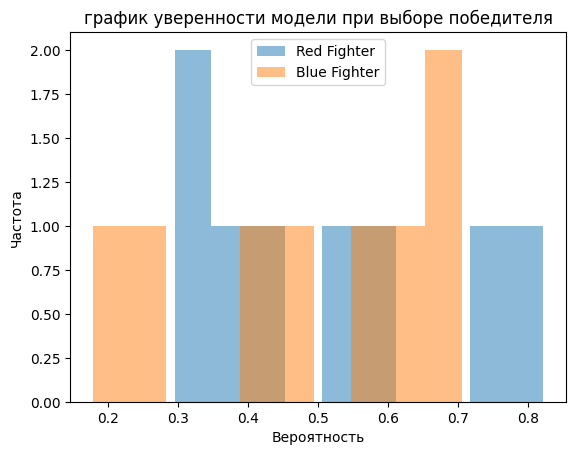

In [58]:
fig, ax = plt.subplots()
ax.hist(y_proba[:, 0], alpha=0.5, label='Red Fighter')
ax.hist(y_proba[:, 1], alpha=0.5, label='Blue Fighter')
ax.set_xlabel('Вероятность')
ax.set_ylabel('Частота')
ax.set_title('график уверенности модели при выборе победителя')
ax.legend()